In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
import pandas as pd

import matplotlib.animation as animation
import IPython

import torch.distributions as tdist

from ipywidgets import interact

from utils import *
from variational_inference_classes import *

%load_ext autoreload
%autoreload 2

$\newcommand{\elbo}{\mathrm{ELBO}}$
$\newcommand{\kl}{\mathrm{KL}}$
$\newcommand{\set}[1]{ \left\{ #1 \right\}}$
$\def\R{{\mathbb R}}$
$\def\Q{{\mathbb Q}}$
$\def\E{{\mathbb E}}$
$\def\C{{\mathbb C}}$
$\def\N{{\mathbb N}}$
$\def\Z{{\mathbb Z}}$

$\newcommand{\brac}[1]{\left(#1\right)}$
$\newcommand{\abs}[1]{\left|\, #1\,\right|}$
$\newcommand{\p}{\partial}$
$\newcommand{\abrac}[1]{\left\langle #1 \right\rangle}$
$\newcommand{\sqbrac}[1]{\left[ #1 \right]}$
$\newcommand{\st}{\, \, : \,}$
$\newcommand{\supp}{\mathrm{supp}}$
$\newcommand{\norm}[1]{\lVert #1 \rVert}$
$\renewcommand{\d}[1]{\, \mathrm{d}#1 \,}$

# Unit tests (Making sure that code works as intended)

## Unit test 1: Gaussian family VI to learn known Gaussian posterior
Will try to do variational inference against toy Gaussian posterior to make sure that the code has intended behaviour. 

We will attempt to approximate the normal distribution 
$$
p(\xi) = \frac{1}{(2\pi)^{d/2} \sqrt{\mathrm{det}(\sigma_0^2I_d)}} e^{\frac{1}{2\sigma_0^2}\sum_{j = 1}^d (\xi_j - \mu_{0j})^2}. 
$$

We shall find a distribution from the following Gaussian family
$$
\mathcal{Q}_{gaussian} = \set{q_{\mu, \sigma}(\xi) = \frac{1}{(2\pi)^{d/2} \sqrt{\mathrm{det}(\sigma^2I_d)}} e^{\frac{1}{2\sigma^2}\sum_{j = 1}^d (\xi_j - \mu_{j})^2} \st \mu \in \R^d, \sigma \in \R_{> 0}}
$$


In this case, we have ELBO given by 
$$
-\elbo(q) = \E_q\sqbrac{\log \frac{q(\xi)}{e^{-\frac{1}{2\sigma_0^2}\sum_j (\xi_j - \mu_{0j})^2}}} = \E_q \log q(\xi) + \frac{1}{2\sigma_0^2} \E_q \sum_j (\xi_j - \mu_{0j})^2
$$

Epoch     0: mu=[0.83 0.95], sigma=[0.9717500805854797, 1.0962616205215454], elbo=0.41
Epoch   400: mu=[0.57 0.62], sigma=[0.7132512927055359, 1.6079905033111572], elbo=1.87
Epoch   800: mu=[0.51 0.43], sigma=[0.5936216115951538, 2.219341278076172], elbo=2.11
Epoch  1200: mu=[0.5  0.33], sigma=[0.538224458694458, 2.714916229248047], elbo=2.22
Epoch  1600: mu=[0.5  0.31], sigma=[0.5141323208808899, 2.928609609603882], elbo=2.23
Epoch  2000: mu=[0.5 0.3], sigma=[0.503479540348053, 2.9832847118377686], elbo=2.24
Epoch  2400: mu=[0.5  0.31], sigma=[0.5021281242370605, 2.9988455772399902], elbo=2.24
Epoch  2800: mu=[0.5  0.29], sigma=[0.5007122159004211, 3.0188441276550293], elbo=2.24
Epoch  3200: mu=[0.5 0.3], sigma=[0.4968884587287903, 2.9908294677734375], elbo=2.24
Epoch  3600: mu=[0.5  0.31], sigma=[0.5044863820075989, 2.9844532012939453], elbo=2.24


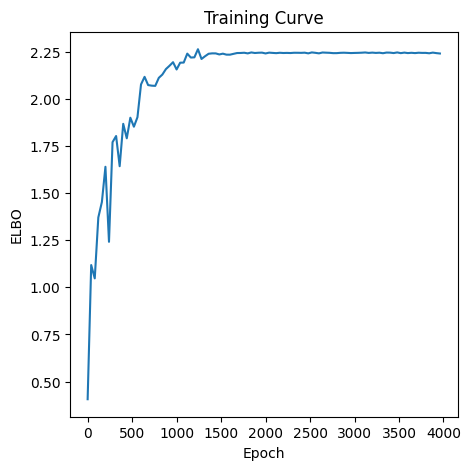

In [2]:
gaussian_vi = GaussianFamilyOn2DGaussianPosterior(
    mu_0=torch.tensor([0.5, 0.3]), 
    sigma_0=torch.tensor([0.5, 3.])
)
gaussian_vi.run_parameter_optimisation(4000)
fig = gaussian_vi.plot_training_curve();

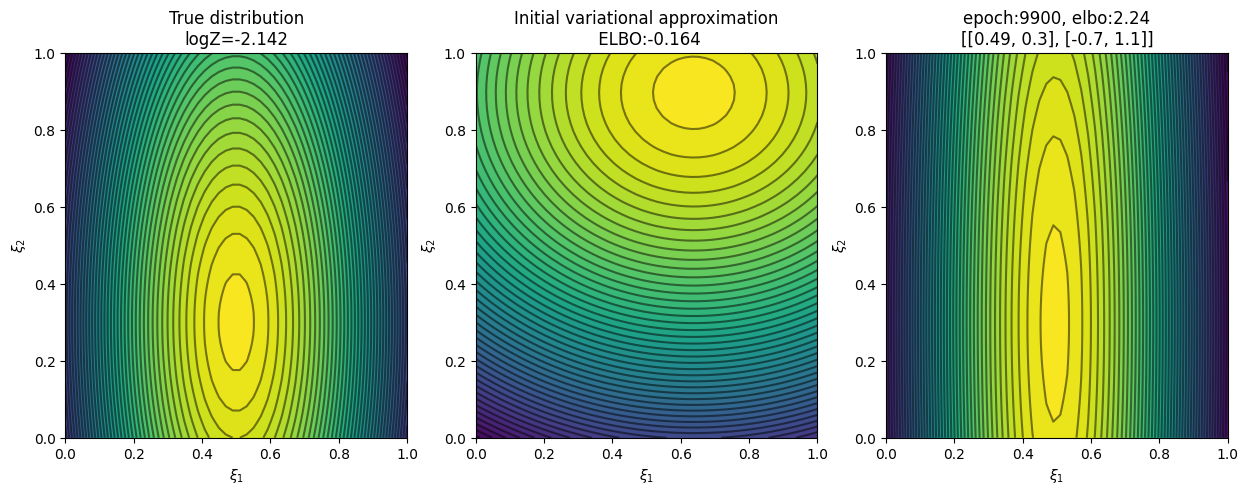

In [3]:
fig, video = gaussian_vi.plot_variational_posterior(animate=True);
IPython.display.display(IPython.display.HTML(video))

## Unit test 2: Mean field generalised gamma family to learn mean field generalised gamma

Here we try to use a mean-field generalised gamma family to learn a known generalised gamma distribution: 
$$
p(\xi) = \prod_{j = 1}^2 \frac{\beta_{0j}^{\lambda_{0j}}}{\Gamma(\lambda_{0j})} \xi_j^{2k_{0j}\lambda_{0j} - 1} e^{-\beta_{0j}\xi_j^{2k_{0j}}}
$$

The mean-field generalised gamma variational family is given by
$$
\mathcal{Q}_{gamma} := \set{
q_{\theta}(\xi) = \prod_{j = 1}^2 \frac{2k_j\beta_j^{\lambda_j}}{\gamma(\lambda_j, \beta_j)\Gamma(\lambda)} \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}} \st \theta = (\lambda_1, \lambda_2, k_1, k_2, \beta_1, \beta_2) \in \R^{3d}_{\geq 0}}
$$

In this case, we have ELBO given by 
$$
-\elbo(q) = \E_q\sqbrac{\log \frac{q(\xi)}{\prod_{j = 1}^2 \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}} }} = \E_q \log q(\xi) + \frac{1}{2\sigma_0^2} \E_q \sum_j (\xi_j - \mu_{0j})^2
$$

In [4]:
# TODO

# Standard Form
We are assuming that our posterior is of the form 
$$
p(\xi_1, \xi_2) = \frac{1}{\overline{Z}_n} \xi_1^{h_1} \xi_2^{h_2} e^{-n \xi_1^{2k_1} \xi_2^{2k_2}}, \quad (\xi_1, \xi_2) \in [0, 1]^2
$$
where $\overline{Z}_n = \int_{[0, 1]^2} \xi_1^{h_1} \xi_2^{h_2} e^{-n \xi_1^{2k_1} \xi_2^{2k_2}} d\xi_1 d\xi_2$ is the normalising constant, a.k.a. the evidence.  

The posterior contours would look like the following:

In [86]:
N = 200
a, b = 0, 1
xx, yy = np.meshgrid(np.linspace(a, b, num=N), np.linspace(a, b, num=N))
w = np.stack((xx, yy), axis=-1)

@interact(
    n=(2, 100000),
    k1=(0, 10),
    k2=(0, 10),
    h1=(0, 10),
    h2=(0, 10)
)
def _plot_contour(n=500, k1=7, k2=5, h1=1, h2=3):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    h = np.array([h1, h2])
    k = np.array([k1, k2])
    boltzman_weight = lambda w: np.abs(np.prod(w**h, axis=-1)) * np.exp(-n * np.prod(w ** (2 * k), axis=-1))
    integrand = lambda y, x: boltzman_weight(np.array([x, y]))
    z = boltzman_weight(w)
    evidence = scipy.integrate.dblquad(integrand, 0, 1, 0, 1)

    normalising_const = np.sum(z) / (N**2)
    lambdas = (h + 1) / (2 * k)
    rlct = np.min(lambdas)
    m = np.sum(lambdas == rlct)
    const_term = (
        scipy.special.loggamma(rlct)
        - np.sum(np.log(2 * k))
        - np.log(2 * k[1] * (lambdas[1] - lambdas[0]))
    )
#     index = np.argsort(lambdas)[m:]
#     const_term -= np.sum(np.log(2 * k[index]) + np.log(lambdas[index] - rlct))
    
#     if m == 2: 
#         const_term -= np.sum(np.log(k))
#     elif m == 1:
#         i = np.argmin(lambdas)
#         j = np.argmax(lambdas)
#         const_term -= np.log(k[i])
#         const_term -= np.log(lambdas[j] - lambdas[i])
    
    leading_terms = rlct * np.log(n) - (m -1) * np.log(np.log(n))
    print(
        f"lambdas          = {lambdas}\n"
        f"evidence         = {evidence}\n"
        f"-logZ integrated = {-np.log(evidence[0])}\n"
        f"-logZ_approx     = {leading_terms - const_term}\n"
        f"-logZ_...        = {-logZ_approx(k, h, n)}\n"
        f"-logZ grid sum   = {-np.log(normalising_const)}\n"
        f"rlct log(n) - (m - 1) log log n         = {leading_terms}\n"
        
        f"RLCT             = {rlct}\n"
        f"m                = {m}\n"
        f"const            = {const_term}\n"
        f"Residue          = {-np.log(evidence[0]) - leading_terms + const_term}\n"
    )
    ax.contourf(xx, yy, z / normalising_const, levels=100)
    ax.set_xlabel("$\\xi_1$")
    ax.set_ylabel("$\\xi_2$")

interactive(children=(IntSlider(value=500, description='n', max=100000, min=2), IntSlider(value=7, description…

Given a variational family $\mathcal{Q}$, we wish to find a variational approximation $\hat{q} \in \mathcal{Q}$ that minimises the KL-divergence $KL(\hat{q} || p(\xi_1, \xi_2)$. Notice though that this is equivalent to maximising the ELBO = Evidence Lower Bound: 
$$
\elbo(q)= -\E_q\sqbrac{n\xi^{2k}} - \E_q \log \frac{q(\xi)}{\xi^h} \\
$$

This can be shown by the following calculation. 
$$
\begin{align*}
  \kl(q||p) 
  &= \E_q\log \frac{q(\xi)}{p(\xi)}\\
  &= \log \overline{Z}_n + \E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2} e^{-n \xi_1^{2k_1} \xi_2^{2k_2}}} \\
  &= \log \overline{Z}_n + \E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}} + \E_q n \xi_1^{2k_1} \xi_2^{2k_2}\\
\end{align*}
$$
Since $\kl(q||p) \geq 0$, we can bound the log-evidence with 
$$
  \log \overline{Z}_n \geq -\E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}} - \E_q n \xi_1^{2k_1} \xi_2^{2k_2} =: \elbo(q)
$$

# Experiment 1: Learning 2D standard form posterior 

## Experiment 1.0: Learning with Gaussian Family



We shall first use a simple Gaussian family of distribution for variational inference. 
$$
\mathcal{Q}_{gaussian} := \set{q_{\mu_1, \mu_2, \sigma}(\xi) = \frac{1}{2\pi \sigma^2} e^{-\frac{1}{2\sigma^2} \sqbrac{(\xi_1 - \mu_1)^2 + (\xi_2 - \mu_2)^2}} \st \mu_1, \mu_2 \in \R, \sigma \in (0, \infty)}
$$

To maximise $\elbo(q)$ for $q \in \mathcal{Q}_{gaussian}$ via gradient descent on the variational parameters $\theta = (\mu_1, \mu_2, \sigma)$, we need unbiased estimate for the gradient $\nabla_{\theta} \elbo(q)$. We can apply the reparametrisation trick to the above gaussian family as follow, for each $j = 1, 2$
 1. We sample noise $\epsilon_j$ independently from $N(0, 1)$. 
 2. Set $\xi_j = \mu_j + \sigma \epsilon_j$. 

This construction implies that $\xi_j \sim N(\mu_j, \sigma^2)$ and $(\xi_1, \xi_2) \sim q_\theta$. We can then estimate the gradient of ELBO as
$$
\begin{align*}
  -\nabla_\theta \elbo(q_\theta) 
  &= \nabla_\theta \E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}} + \E_q n \xi_1^{2k_1} \xi_2^{2k_2}\\
  &= \nabla_\theta \E_q\log q(\xi) -  \E_q \log(\xi_1^{h_1} \xi_2^{h_2}) + \E_q n \xi_1^{2k_1} \xi_2^{2k_2}
\end{align*}
$$

tensor([7., 5.])
tensor([1., 3.])
tensor([0.1429, 0.4000])
logZ=-4.338849785630035
Epoch      0: mu=[0.6 0.9], sigma=[0.09990005195140839, 0.9990004897117615], elbo=-151853248.00
Epoch   4000: mu=[0.39 0.7 ], sigma=[0.085018090903759, 0.840827465057373], elbo=-1657035.62
Epoch   8000: mu=[0.33 0.64], sigma=[0.08061456680297852, 0.8047103881835938], elbo=-121550.07
Epoch  12000: mu=[0.28 0.6 ], sigma=[0.07690490782260895, 0.7771749496459961], elbo=-9721.73
Epoch  16000: mu=[0.23 0.56], sigma=[0.07355962693691254, 0.7544391751289368], elbo=-2895.02
Epoch  20000: mu=[0.18 0.52], sigma=[0.07029111683368683, 0.7340000867843628], elbo=-361.58
Epoch  24000: mu=[0.15 0.5 ], sigma=[0.0681719034910202, 0.72109055519104], elbo=-30.22
Epoch  28000: mu=[0.11 0.48], sigma=[0.06592358648777008, 0.7088815569877625], elbo=-5.54
Epoch  32000: mu=[0.09 0.43], sigma=[0.06253080815076828, 0.6972624063491821], elbo=-5.12
Epoch  36000: mu=[0.07 0.45], sigma=[0.06169915571808815, 0.6879938244819641], elbo=-5.

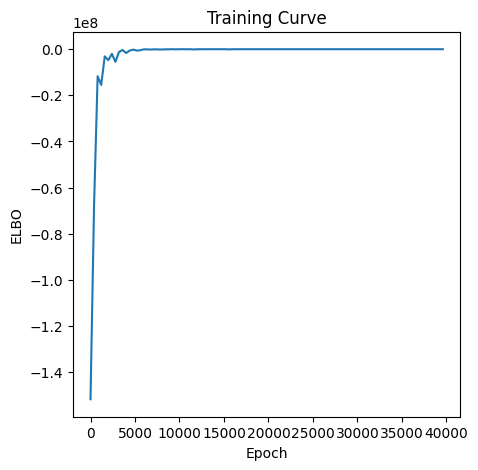

In [34]:
n = 100000000
k_0 = torch.tensor([7., 5.])  # assume no "flat" dimensions with k_j = 0
h_0 = torch.tensor([1., 3.])
lambda_0 = (h_0 + 1) / (2 * k_0)
print(k_0)
print(h_0)
print(lambda_0)


gaussian_on_standard_form = GaussianFamilyOn2DStandardForm(
    n=n,
    k_0=k_0,
    h_0=h_0, 
    lr=0.001, 
    init_mu=torch.tensor([0.6, 0.9]),
    init_logsigma=torch.log(torch.tensor([0.1, 1]))
)
print(f"logZ={gaussian_on_standard_form.log_evidence()}")

gaussian_on_standard_form.run_parameter_optimisation(40000)
fig = gaussian_on_standard_form.plot_training_curve();

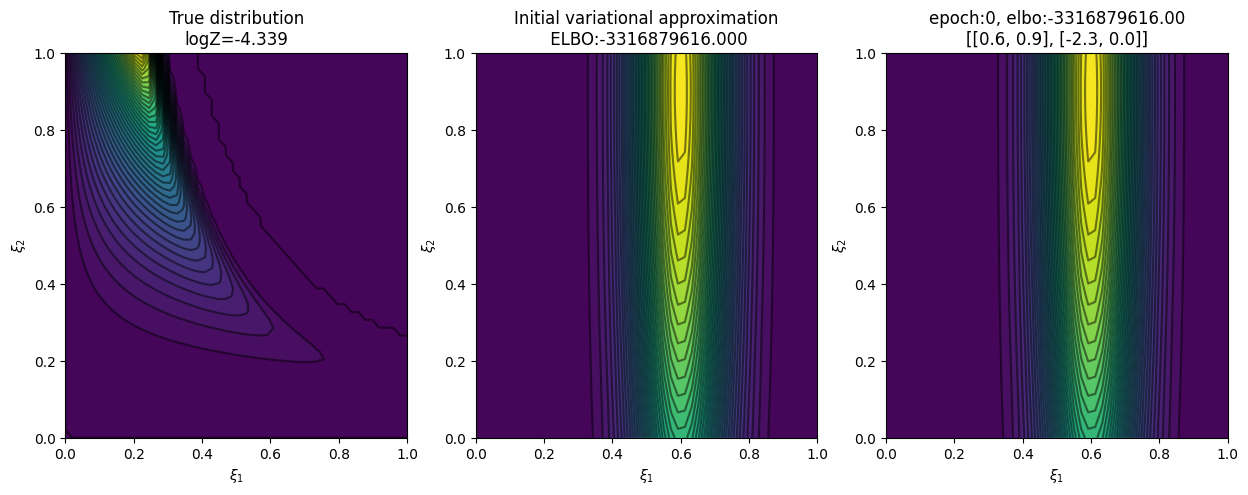

In [35]:
fig, anim = gaussian_on_standard_form.plot_variational_posterior(animate=True);
if anim is not None:
    video = anim.to_html5_video()
    IPython.display.display(IPython.display.HTML(video))
anim.save("gaussian_on_standard_form.mp4")

# Experiment 2: Learning 2D standard form with Gamma Mean Field Family

## Generalised Gamma Mean Field Family and its ELBO
Our variational family in this case is a mean field family of generalised gamma distributions.
$$
\mathcal{Q}_{gamma} := \set{
q_{\theta}(\xi) = \prod_{j = 1}^2 \frac{2k_j\beta_j^{\lambda_j}}{\Gamma(\lambda)} \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}} \st \theta = (\lambda_1, \lambda_2, k_1, k_2, \beta_1, \beta_2) \in \R^{3d}_{\geq 0}, \xi \in [0, \infty)}
$$

The expression for ELBO is given by
$$
\begin{align*}
  - \elbo(q_\theta) 
  &= \E_q n \xi_1^{2k_{01}} \xi_2^{2k_{02}} + \E_q\log \frac{q(\xi)}{\xi_1^{h_{01}} \xi_2^{h_{02}}}\\
\end{align*}
$$

<p style="color:red;font-size:large">
    Warning: The above expression might not be correct due to the fact that the support of mean-field gamma density is larger than that of the standard form on $[0, 1]^2$
</p>

The first term is given by (with $d = 2$ below)
$$
\begin{align*}
\E_q n \xi_1^{2k_1} \xi_2^{2k_2}
&= n \prod_{j = 1}^d \int_0^\infty q_j(\xi_j) \xi_j^{2k_{0j}} d\xi_j\\
&= n \prod_{j = 1}^d \frac{2k_j\beta_j^{\lambda_j}}{\Gamma(\lambda_j)} \int_0^\infty \xi_j^{2k_j \lambda_j +2k_{0j} -1} e^{-\beta_j \xi_j^{2k_j}} d\xi_j \\
&= n \prod_{j = 1}^d \frac{2k_j\beta_j^{\lambda_j}}{\Gamma(\lambda_j)} \frac{1}{2k_j\beta_j^{\lambda_j + \frac{k_{0j}}{k_j}}}\Gamma\brac{\lambda_j + \frac{k_{0j}}{k_j}}\\
&= n \prod_{j = 1}^d \frac{1}{ \beta_j^{k_{0j} / k_j}}\frac{\Gamma\brac{\lambda_j + \frac{k_{0j}}{k_j}}}{\Gamma(\lambda_j)}
\end{align*}
$$

The second term is given by 
$$
\begin{align*}
\E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}}
&= \sum_{j = 1}^d \int_0^\infty q_j(\xi_j) \log \frac{q(\xi_j)}{\xi_j^{2\lambda_{0j} k_{0j} -1}}d\xi_j\\
&= \sum_{j = 1}^d \int_0^\infty q_j(\xi_j) \log \frac{\frac{2k_j\beta_j^{\lambda_j}}{\Gamma(\lambda)} \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}}}{\xi_j^{2\lambda_{0j} k_{0j} -1}}d\xi_j\\
&= \sum_{j = 1}^d \log\brac{\frac{2k_j\beta_j^{\lambda_j}}{\Gamma(\lambda_j)} } 
- \beta_j \int_0^\infty q(\xi_j) \xi_j^{2k_j} d\xi_j
+ \brac{2k_j \lambda_j - 2k_{0j}\lambda_{0j}}\int_0^\infty q_j(\xi_j) \log \xi_j d\xi_j\\
&=  \sum_{j = 1}^d 
\log(2k_j) + \lambda_j\log \beta_j - \log \Gamma(\lambda_j)
- \beta_j \frac{\beta_j^{\lambda_j}2k_j}{\Gamma(\lambda_j)} \frac{\Gamma(\lambda_j + 1)}{2k_j \beta_j^{\lambda_j + 1}}
+ \brac{2k_j \lambda_j - 2k_{0j}\lambda_{0j}}\int_0^\infty q_j(\xi_j) \log \xi_j d\xi_j\\
&=  \sum_{j = 1}^d 
\log(2k_j) + \lambda_j\log \beta_j - \log \Gamma(\lambda_j)
- \lambda_j
+ \brac{2k_j \lambda_j - 2k_{0j}\lambda_{0j}}\frac{1}{2k_j}\brac{\psi(\lambda_j) - \log \beta_j}\\
&=  \sum_{j = 1}^d 
\log(2k_j) + \lambda_j\log \beta_j - \log \Gamma(\lambda_j)
- \lambda_j
+ \brac{\lambda_j - \frac{k_{0j}}{k_j}\lambda_{0j}}\brac{\psi(\lambda_j) - \log \beta_j}. 
\end{align*}
$$

To evaluate $\E_{q_j}\log \xi_j$, we have use the following observation 
$$
\frac{d}{d\lambda}\Gamma(\lambda) = \int_0^\infty e^{-t} \frac{d}{d\lambda}t^{\lambda -1} dt = \int_0^\infty e^{-t} t^{\lambda -1} \log t dt
$$
and hence, using the substitution $t =\beta \xi^{2k}$
$$
\begin{align*}
\E_{q} \log \xi 
&= \frac{2k\beta^{\lambda}}{\Gamma(\lambda)}\int_0^\infty e^{-\beta \xi^{2k}} \xi^{2\lambda k - 1} \log \xi d\xi\\
&= \frac{2k\beta^{\lambda}}{\Gamma(\lambda)}\int_0^\infty e^{-t} \brac{\frac{t}{\beta}}^{\lambda - 1/(2k)} \log\brac{\frac{t}{\beta}}^{1/(2k)} \frac{t^{1/(2k) - 1}}{2k\beta^{1/(2k)}} dt\\
&= \frac{2k\beta^{\lambda}}{\Gamma(\lambda)}\frac{1}{4k^2 \beta^\lambda}\int_0^\infty e^{-t} t^{\lambda -1} \brac{\log t - \log \beta}dt\\
&= \frac{1}{2k\Gamma(\lambda)}\brac{\int_0^\infty e^{-t} t^{\lambda -1} \log t dt - \log \beta \int_0^\infty e^{-t}t^{\lambda -1} dt}\\
&= \frac{1}{2k\Gamma(\lambda)}\brac{\Gamma'(\lambda) - \Gamma(\lambda)\log \beta }\\
&= \frac{1}{2k}\brac{\frac{\Gamma'(\lambda)}{\Gamma(\lambda)} - \log \beta}\\
&= \frac{1}{2k}\brac{\psi(\lambda) - \log \beta}\\
\end{align*}
$$


# Experiment 2.1: Optimising all parameters ($\lambda$, $k$, $\beta_2$)

Note: 
 * It seems like making $\beta$ really large in the above expression maximises the ELBO expression .. This might be a consequence of the fact that the vairational distribution is not absolutely continuous w.r.t. the posterior ...? 
 * But with $n$ large or $\beta$ large, the constribution outside of the unit cube shouldn't matter much ...? 
 
 
<p style="color:red;font-size:large">
    Warning: While the following run converges, it violates the variational lower bound
</p>

n        = 1000
lambda_0 = tensor([0.1400, 0.4000])
ks_0     = tensor([7, 5])
h_0      = tensor([1, 3])

logZ=-2.7502
Epoch     0: elbo=-2.77, lambdas=[0.14, 0.4], ks=[7.01, 5.01], betas=[1000.0, 1.0]
Epoch  1000: elbo=-0.63, lambdas=[0.34, 1.5], ks=[2.7, 1.15], betas=[1000.0, 0.3]
Epoch  2000: elbo=12.97, lambdas=[2.56, 7.38], ks=[0.35, 0.31], betas=[1000.0, 0.08]
Epoch  3000: elbo=49.95, lambdas=[16.72, 32.7], ks=[0.06, 0.13], betas=[1000.0, 0.02]
Epoch  4000: elbo=73.79, lambdas=[54.46, 98.22], ks=[0.03, 0.1], betas=[1000.0, 0.01]
Epoch  5000: elbo=76.10, lambdas=[61.41, 185.48], ks=[0.02, 0.11], betas=[1000.0, 0.01]
Epoch  6000: elbo=76.73, lambdas=[61.05, 285.12], ks=[0.02, 0.11], betas=[1000.0, 0.0]
Epoch  7000: elbo=76.95, lambdas=[60.86, 392.95], ks=[0.02, 0.12], betas=[1000.0, 0.0]
Epoch  8000: elbo=77.03, lambdas=[60.76, 495.94], ks=[0.02, 0.12], betas=[1000.0, 0.0]
Epoch  9000: elbo=77.05, lambdas=[60.71, 575.2], ks=[0.02, 0.12], betas=[1000.0, 0.0]


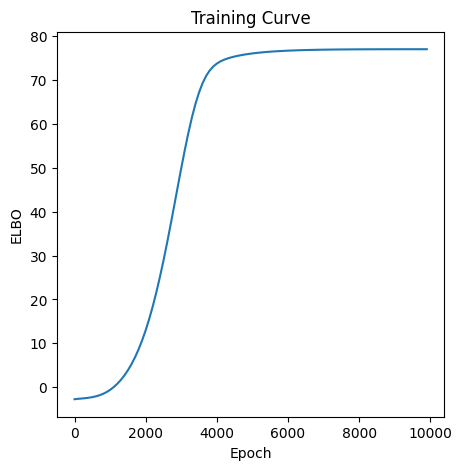

In [8]:
n = 1000
k_0 = torch.tensor([7, 5])  # assume no "flat" dimensions with k_j = 0
h_0 = torch.tensor([1, 3])
lambda_0 = (h_0 + 1) / (2 * k_0)

print(
    f"n        = {n}\n"
    f"lambda_0 = {np.around(lambda_0.detach(), 2)}\n"
    f"ks_0     = {np.around(k_0.detach(), 2)}\n"
    f"h_0      = {np.around(h_0.detach(), 2)}\n"
)

mean_field_gamma_on_standard_form = MeanFieldGammaOn2DStandardForm(
    n=n,
    k_0=k_0,
    lambda_0=lambda_0, 
    lambdas_grad=True, 
    ks_grad=True, 
    beta1_grad=False,
)
print(f"logZ={mean_field_gamma_on_standard_form.log_evidence():.4f}")
mean_field_gamma_on_standard_form.run_parameter_optimisation(10000)
mean_field_gamma_on_standard_form.plot_training_curve();

/home/edmund/.local/share/virtualenvs/variational-approximation-for-singular-mod-T_CFu1la/lib/python3.9/site-packages/matplotlib/contour.py:1479: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/edmund/.local/share/virtualenvs/variational-approximation-for-singular-mod-T_CFu1la/lib/python3.9/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/home/edmund/variational-approximation-for-singular-models/notebooks/variational_inference_classes.py:127: UserWarning: No contour levels were found within the data range.
  contour = ax.contour(xx, yy, z, levels=levels, colors="k", alpha=0.5)
/home/edmund/variational-approximation-for-singular-models/notebooks/variational_inference_classes.py:148: UserWarning: No contour levels were found within the data range.
  contour = ax.contour(xx, yy, z, levels=levels, colors="k", alpha=0.5)
/home/edmund/.local/share/virtualenvs/variatio

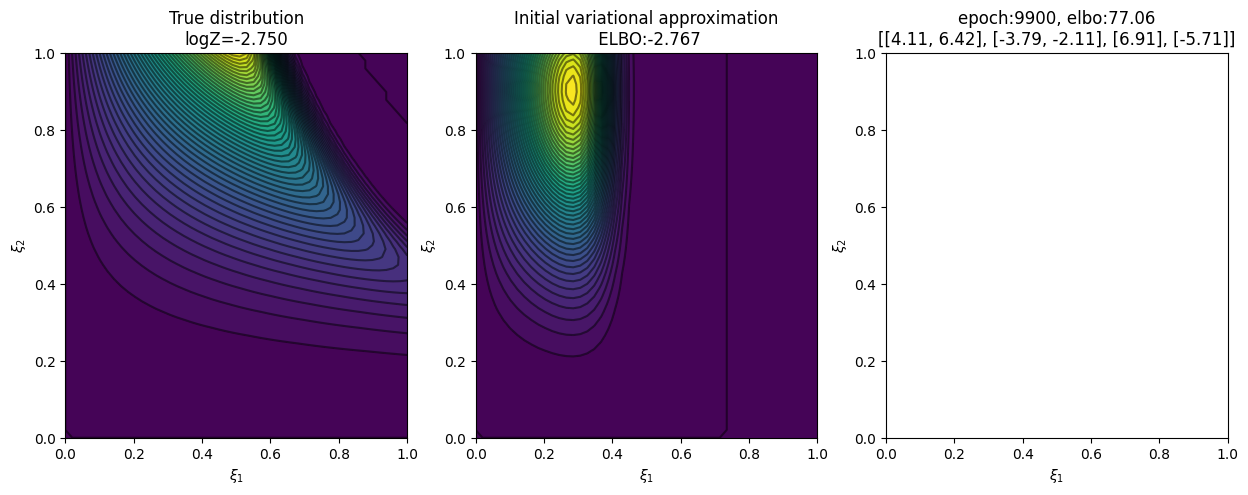

In [9]:
fig, video = mean_field_gamma_on_standard_form.plot_variational_posterior(animate=True);
IPython.display.display(IPython.display.HTML(video))


## Experiment 2.2: Optimising only $\beta_2$
<p style="color:red;font-size:large">
    Warning: While the following run converges, it violates the variational lower bound
</p>

Notes: 
 * It seems like even when the $\lambda$ and $k$ are freezed to the true value, the $\beta$ corresponding to the smallest $\lambda$ goes to $\infty$ while the other one goes to $0$. 

n        = 1000
lambda_0 = tensor([0.1400, 0.4000])
ks_0     = tensor([7, 5])
h_0      = tensor([1, 3])
logZ=-2.7502

Epoch     0: elbo=-2.77, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 1.0]
Epoch   400: elbo=-2.64, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 0.67]
Epoch   800: elbo=-2.53, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 0.46]
Epoch  1200: elbo=-2.44, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 0.33]
Epoch  1600: elbo=-2.38, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 0.25]
Epoch  2000: elbo=-2.35, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 0.19]
Epoch  2400: elbo=-2.34, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 0.17]
Epoch  2800: elbo=-2.33, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 0.15]
Epoch  3200: elbo=-2.33, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 0.15]
Epoch  3600: elbo=-2.33, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 0.14]


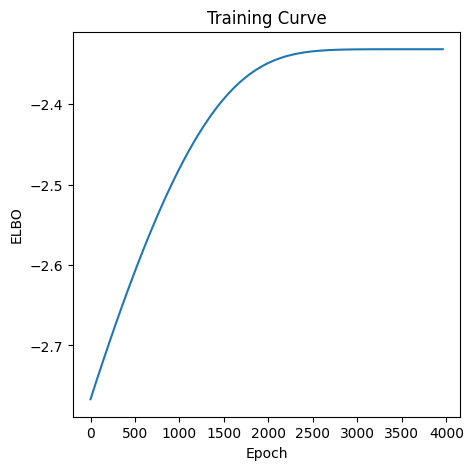

In [3]:
n = 1000
k_0 = torch.tensor([7, 5])  # assume no "flat" dimensions with k_j = 0
h_0 = torch.tensor([1, 3])
lambda_0 = (h_0 + 1) / (2 * k_0)

print(
    f"n        = {n}\n"
    f"lambda_0 = {np.around(lambda_0.detach(), 2)}\n"
    f"ks_0     = {np.around(k_0.detach(), 2)}\n"
    f"h_0      = {np.around(h_0.detach(), 2)}"
)

meanfield_gamma_restricted_on_standard_form = MeanFieldGammaOn2DStandardForm(
    n=n,
    k_0=k_0,
    lambda_0=lambda_0, 
    lambdas_grad=False, 
    ks_grad=False, 
    beta1_grad=False,
)
print(f"logZ={meanfield_gamma_restricted_on_standard_form.log_evidence():.4f}\n")

meanfield_gamma_restricted_on_standard_form.run_parameter_optimisation(4000)
meanfield_gamma_restricted_on_standard_form.plot_training_curve();

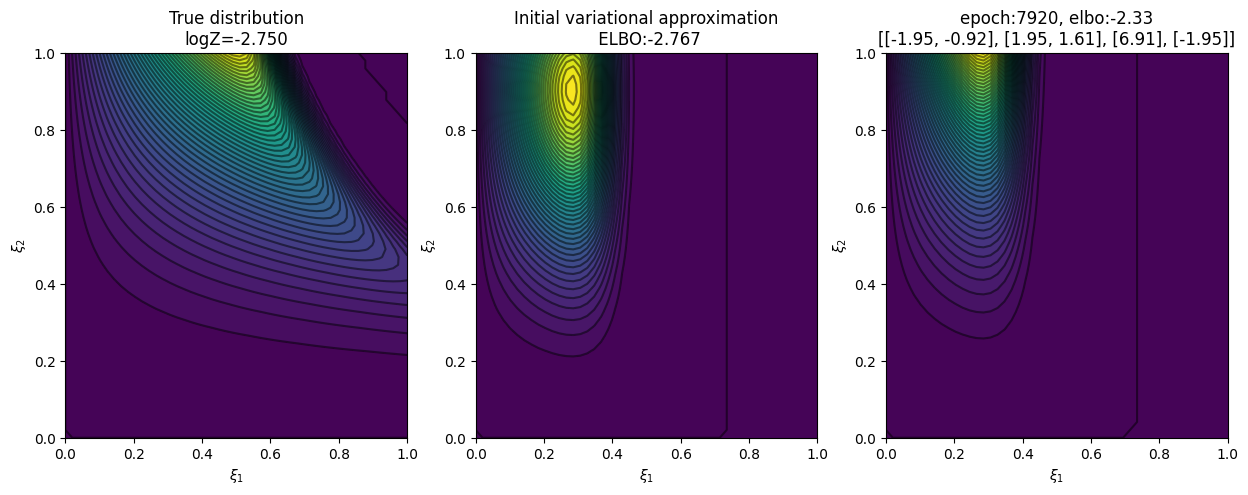

In [11]:
fig, video = meanfield_gamma_restricted_on_standard_form.plot_variational_posterior(animate=True);
IPython.display.display(IPython.display.HTML(video))


### Plotting saved snapshots 

In [2]:
N = 200
a, b = 0, 1
xx, yy = np.meshgrid(np.linspace(a, b, num=N), np.linspace(a, b, num=N))
w = np.stack((xx, yy), axis=-1)

@interact(
    snapshot_index=(0, len(meanfield_gamma_restricted_on_standard_form.snapshots) -1)
)
def _plot(snapshot_index=0):
    epoch, parameters, elbo = meanfield_gamma_restricted_on_standard_form.snapshots[snapshot_index]
    lambdas, ks, beta1, beta_rest = [
        torch.exp(param).detach() for param in parameters
    ]
    betas = torch.concat([beta1, beta_rest])
    print(f"Epoch: {epoch}, ELBO: {elbo.item():.3f}")
    print(lambdas, ks, betas)
    print(f"Mean coords: {2 * ks * (betas**lambdas) / torch.exp(torch.lgamma(lambdas))}")
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    z = meanfield_gamma_restricted_on_standard_form.variational_density(
        torch.tensor(w), 
        [param.detach() for param in meanfield_gamma_restricted_on_standard_form.parameters]
    )

    ax.contourf(xx, yy, z, levels=100)
    ax.set_xlabel("$\\xi_1$")
    ax.set_ylabel("$\\xi_2$");

NameError: name 'meanfield_gamma_restricted_on_standard_form' is not defined

# Experiment 3: Learning 2D standard form with Truncated Generalised Gamma Mean Field Family
Our variational family in this case is a mean field family of truncated generalised gamma distributions.
$$
\mathcal{Q}_{gamma} := \set{
q_{\theta}(\xi) = \prod_{j = 1}^2 \frac{2k_j\beta_j^{\lambda_j}}{\gamma(\lambda_j, \beta_j)\Gamma(\lambda)} \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}} \st \theta = (\lambda_1, \lambda_2, k_1, k_2, \beta_1, \beta_2) \in \R^{3d}_{\geq 0}, \xi \in [0, 1)}
$$

ELBO expression: 
<p style="color:red;font-size:large"> TODO </p>

## Experiment 3.1: Optimising only $\beta_2$

n        = 1000
lambda_0 = tensor([0.1400, 0.4000])
ks_0     = tensor([7, 5])
logZ     = -2.750

Epoch     0: elbo=-3.70, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[499.5, 14.99]
Epoch  1000: elbo=-3.23, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[196.59, 5.67]
Epoch  2000: elbo=-3.02, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[128.47, 2.74]
Epoch  3000: elbo=-2.97, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[158.79, 1.73]
Epoch  4000: elbo=-2.95, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[193.51, 1.22]
Epoch  5000: elbo=-2.95, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[214.2, 0.93]
Epoch  6000: elbo=-2.94, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[226.33, 0.77]
Epoch  7000: elbo=-2.94, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[233.41, 0.67]
Epoch  8000: elbo=-2.94, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[237.08, 0.62]
Epoch  9000: elbo=-2.94, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[238.47, 0.6]


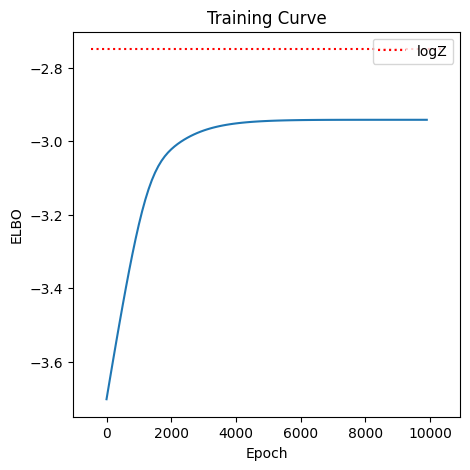

In [11]:
n = 1000
k_0 = torch.tensor([7, 5])  # assume no "flat" dimensions with k_j = 0
h_0 = torch.tensor([1, 3])
lambda_0 = (h_0 + 1) / (2 * k_0)

init_params = [
    lambda_0, 
    k_0, 
    torch.tensor([n - 500, 15])
]
# init_params = None
meanfield_truncated_gamma_restricted_on_standard_form = MeanFieldTruncatedGammaOn2DStandardForm(
    n=n,
    k_0=k_0,
    lambda_0=lambda_0, 
    lr=0.001, 
    lambdas_grad=False, 
    ks_grad=False, 
    beta1_grad=True, 
    init_params=init_params
)

logZ = meanfield_truncated_gamma_restricted_on_standard_form.log_evidence()
print(
    f"n        = {n}\n"
    f"lambda_0 = {np.around(lambda_0.detach(), 2)}\n"
    f"ks_0     = {np.around(k_0.detach(), 2)}\n"
    f"logZ     = {logZ:.3f}\n"
)


meanfield_truncated_gamma_restricted_on_standard_form.run_parameter_optimisation(10000)
fig = meanfield_truncated_gamma_restricted_on_standard_form.plot_training_curve();
ax = fig.axes[0]
xmin, xmax = ax.get_xlim()
ax.hlines([logZ], xmin, xmax, color="red", linestyle="dotted", label="logZ")
ax.legend()

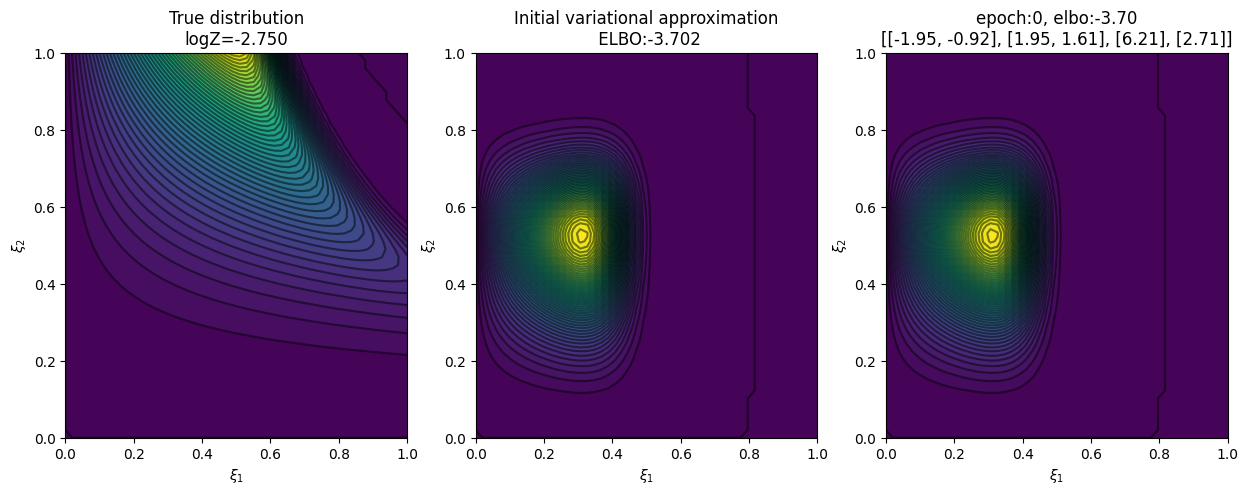

In [10]:
fig, anim = meanfield_truncated_gamma_restricted_on_standard_form.plot_variational_posterior(animate=True);
if anim is not None:
    video = anim.to_html5_video()
    IPython.display.display(IPython.display.HTML(video))
# anim.save("mf_gamma_trunc_optim_beta1_beta2_on_standard_form.mp4")

## Experiment 3.2: Optimising all $\lambda$, $k$, $\beta_2$

<p style="color:red;font-size:large"> 
    WARNING: `igamma` implementation seems to be numerically unstable so this will fail....
</p>

n        = 1000
lambda_0 = tensor([0.1400, 0.4000])
ks_0     = tensor([7, 5])
logZ     = -2.750

Epoch     0: elbo=-3.06, lambdas=[0.14, 0.4], ks=[6.99, 5.0], betas=[1000.0, 1.0]
Epoch   300: elbo=-2.48, lambdas=[0.14, 0.4], ks=[5.24, 3.71], betas=[1000.0, 0.75]
Epoch   600: elbo=-1.92, lambdas=[0.14, 0.4], ks=[3.94, 2.73], betas=[1000.0, 0.53]
Epoch   900: elbo=-1.29, lambdas=[0.14, 0.4], ks=[2.95, 1.97], betas=[1000.0, 0.36]
Epoch  1200: elbo=-0.64, lambdas=[0.14, 0.4], ks=[2.19, 1.42], betas=[1000.0, 0.26]
Epoch  1500: elbo=-0.01, lambdas=[0.14, 0.4], ks=[1.63, 1.03], betas=[1000.0, 0.2]
Epoch  1800: elbo=0.61, lambdas=[0.14, 0.4], ks=[1.21, 0.75], betas=[1000.0, 0.16]
Epoch  2100: elbo=1.22, lambdas=[0.14, 0.4], ks=[0.9, 0.55], betas=[1000.0, 0.13]
Epoch  2400: elbo=1.84, lambdas=[0.14, 0.4], ks=[0.67, 0.41], betas=[1000.0, 0.11]
Epoch  2700: elbo=2.44, lambdas=[0.14, 0.4], ks=[0.49, 0.3], betas=[1000.0, 0.09]


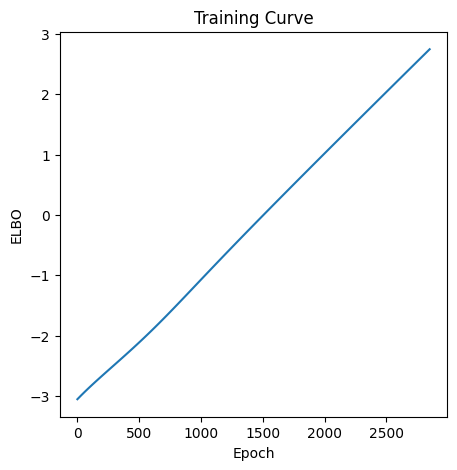

In [127]:
n = 1000
k_0 = torch.tensor([7, 5])  # assume no "flat" dimensions with k_j = 0
h_0 = torch.tensor([1, 3])
lambda_0 = (h_0 + 1) / (2 * k_0)
# init_params = [
#     lambda_0 * 1.3, 
#     k_0 + torch.tensor([9, 2]), 
#     torch.tensor([n, 15])
# ]
init_params = None
meanfield_truncated_gamma_on_standard_form = MeanFieldTruncatedGammaOn2DStandardForm(
    n=n,
    k_0=k_0,
    lambda_0=lambda_0, 
    lr=0.001, 
    lambdas_grad=False, 
    ks_grad=True, 
    beta1_grad=False, 
    init_params=init_params
)
print(
    f"n        = {n}\n"
    f"lambda_0 = {np.around(lambda_0.detach(), 2)}\n"
    f"ks_0     = {np.around(k_0.detach(), 2)}\n"
    f"logZ     = {meanfield_truncated_gamma_on_standard_form.log_evidence():.3f}\n"
)


meanfield_truncated_gamma_on_standard_form.run_parameter_optimisation(3000)
fig = meanfield_truncated_gamma_on_standard_form.plot_training_curve();

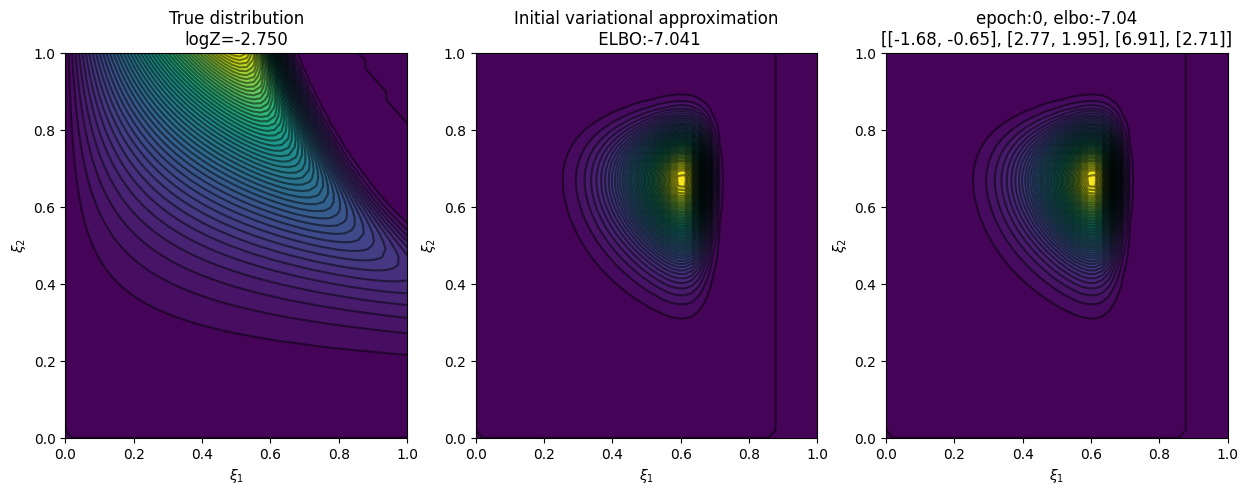

In [125]:
fig, anim = meanfield_truncated_gamma_on_standard_form.plot_variational_posterior(animate=True);
if anim is not None:
    video = anim.to_html5_video()
    IPython.display.display(IPython.display.HTML(video))
# anim.save("mf_gamma_trunc_on_standard_form.mp4")

# $n$-dependencies

In [3]:
from utils import logZ_approx

In [4]:
k_0 = torch.tensor([7., 5.])  # assume no "flat" dimensions with k_j = 0
h_0 = torch.tensor([1., 3.])
# k_0 = torch.tensor([3., 3.])  # assume no "flat" dimensions with k_j = 0
# h_0 = torch.tensor([3., 3.])
lambda_0 = (h_0 + 1) / (2 * k_0)

lr = 0.001
num_epoch = 5000
print(
    f"lambda_0 = {np.around(lambda_0.detach(), 2)}\n"
    f"ks_0     = {np.around(k_0.detach(), 2)}\n"
    f"h_0      = {np.around(h_0.detach(), 2)}\n"
#     f"logZ     = {meanfield_truncated_gamma_restricted_on_standard_form.log_evidence():.3f}\n"
)

rec = []
for logn in range(1, 12):
    n = int(10**logn)
    init_params = [
        lambda_0, 
        k_0, 
        torch.tensor([n, 15])
    ]
    vis = dict(
#         mf_gamma=MeanFieldGammaOn2DStandardForm(
#             n=n,
#             k_0=k_0,
#             lambda_0=lambda_0,
#             lr=lr, 
#             lambdas_grad=False, 
#             ks_grad=False, 
#             beta1_grad=False,
#         ), 
        mf_gamma_trunc=MeanFieldTruncatedGammaOn2DStandardForm(
            n=n,
            k_0=k_0,
            lambda_0=lambda_0, 
            lr=lr, 
            lambdas_grad=False, 
            ks_grad=False, 
            beta1_grad=False,
            init_params=init_params
        ), 
#         gaussian=GaussianFamilyOn2DStandardForm(
#             n=n,
#             k_0=k_0,
#             h_0=h_0, 
#             lr=lr, 
#             init_mu=torch.tensor([0.6, 0.9]),
#             init_logsigma=torch.log(torch.tensor([0.1, 1]))
#         )
    )
    for vi_name, vi in vis.items():
        logZ = vi.log_evidence()
        leading_approx = logZ_approx(k_0.numpy(), h_0.numpy(), n)
        elbo_init = vi.elbo_fn().item()
        vi.run_parameter_optimisation(num_epoch, verbose=False)
        elbo = vi.elbo_fn().item()
        print(f"{vi_name:15s}, n={n:12d}, logZ={logZ:.4f} ({leading_approx:.4f}), "
              f"EBLO_0={elbo_init:.4f}, ELBO={elbo:.4f}")
        
        rec.append([vi_name, n, logZ, leading_approx, elbo_init, elbo])

lambda_0 = tensor([0.1400, 0.4000])
ks_0     = tensor([7., 5.])
h_0      = tensor([1., 3.])

mf_gamma_trunc , n=          10, logZ=-2.2408 (-4.3359), EBLO_0=-3.1389, ELBO=-2.3832
mf_gamma_trunc , n=         100, logZ=-2.4717 (-4.6648), EBLO_0=-3.4678, ELBO=-2.7121
mf_gamma_trunc , n=        1000, logZ=-2.7502 (-4.9938), EBLO_0=-3.7968, ELBO=-3.0410
mf_gamma_trunc , n=       10000, logZ=-3.0523 (-5.3227), EBLO_0=-4.1257, ELBO=-3.3700
mf_gamma_trunc , n=      100000, logZ=-3.3668 (-5.6516), EBLO_0=-4.4547, ELBO=-3.6989
mf_gamma_trunc , n=     1000000, logZ=-3.6877 (-5.9806), EBLO_0=-4.7836, ELBO=-4.0279
mf_gamma_trunc , n=    10000000, logZ=-4.0123 (-6.3095), EBLO_0=-5.1126, ELBO=-4.3568
mf_gamma_trunc , n=   100000000, logZ=-4.3388 (-6.6385), EBLO_0=-5.4415, ELBO=-4.6857
mf_gamma_trunc , n=  1000000000, logZ=-4.6665 (-6.9674), EBLO_0=-5.7704, ELBO=-5.0147
mf_gamma_trunc , n= 10000000000, logZ=-4.9947 (-7.2963), EBLO_0=-6.0994, ELBO=-5.3436
mf_gamma_trunc , n=100000000000, logZ=-5.3232 (

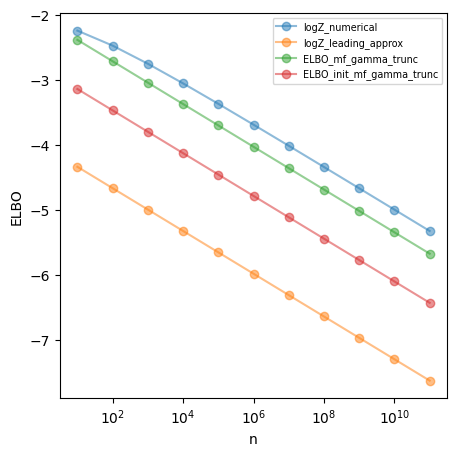

In [5]:
df = pd.DataFrame(rec, index=None)
df.columns = ["name", "n", "logZ_numerical", "logZ_leading_approx", "ELBO_init", "ELBO"]
df = df.set_index("name")
fig,ax = plt.subplots(1, 1, figsize=(5, 5))
alpha=0.5
name = df.index[0]
ax.plot(
    df.loc[name, "n"], 
    df.loc[name, "logZ_numerical"], 
    "o-", 
    label="logZ_numerical", 
    alpha=alpha
)
ax.plot(
    df.loc[name, "n"], 
    df.loc[name, "logZ_leading_approx"], 
    "o-", 
    label="logZ_leading_approx", 
    alpha=alpha
)

for name in df.index.unique():
    if name in ["gaussian"]:
        continue
    d = df.loc[name, :]
    ax.plot(df.loc[name, "n"], df.loc[name, "ELBO"], "o-", label=f"ELBO_{name}", alpha=alpha)
    ax.plot(df.loc[name, "n"], df.loc[name, "ELBO_init"], "o-", label=f"ELBO_init_{name}", alpha=alpha)
#     ax.plot(df.loc[name, "n"], df.loc[name, "ELBO"], "o-", label=f"gamma_trunc_beta2_grad", alpha=alpha)
#     ax.plot(df.loc[name, "n"], df.loc[name, "ELBO_init"], "o-", label=f"gamma_trunc_beta2_nograd", alpha=alpha)

ax.set_xscale('log')
ax.set_xlabel("n")
ax.set_ylabel("ELBO")
ax.legend(fontsize="x-small")

# Experiment 4: Dirichlet family

In [18]:
class DirichletOn2DStandardForm(VariationalInference):
    def __init__(
        self,
        n,
        k_0,
        lambda_0,
        lr=0.001,
        init_params=None, 
        base_samples=1000
    ):
        self.base_samples = base_samples
        self.n = n
        self.k_0 = k_0
        self.lambda_0 = lambda_0
        # making sure that the first lambda_0 is the RLCT
        # this makes it possible to freeze beta1=n is required.
        assert torch.min(self.lambda_0) == self.lambda_0[0]
        self.h_0 = 2 * k_0 * lambda_0 - 1
        self.true_parameters = [self.lambda_0, self.k_0, self.n]
        
        if init_params is not None:
            self.init_concentration = init_params[0]
        else:
            self.init_concentration = torch.ones_like(self.lambda_0) * 0.5
        self.log_concentration = nn.Parameter(torch.log(self.init_concentration))
        self.parameters = [self.log_concentration]
        
        self.optim = torch.optim.Adam(self.parameters, lr=lr)
        super().__init__(self.parameters, self.true_parameters, self.optim)
        
    def elbo_fn(self):
        q = tdist.dirichlet.Dirichlet(concentration=torch.exp(self.log_concentration))
        xi = q.rsample((self.base_samples,))
        term1 = q.log_prob(xi)
        term2 = torch.sum(torch.log(torch.abs(xi)) * self.h_0, dim=1)
        term3 = self.n * torch.prod(xi ** (2 * self.k_0), dim=1)
        elbo = -torch.mean(term1 - term2 + term3)
        return elbo
    
    def report_optim_step(self):
        c = torch.exp(self.log_concentration).detach().tolist()
        print(
            f"Epoch {self.epoch:6d}: concentrations={c}, elbo={self.elbo:.2f}"
        )

    def true_unnormalised_density(self, w):
        return standard_form_unnormlised_density(w, self.k_0, self.h_0, self.n)

    def variational_density(self, w, parameters):
        log_concentration = parameters[0]
        q = tdist.dirichlet.Dirichlet(
            concentration=torch.exp(log_concentration)
        )
        z = np.exp(q.log_prob(w))
        return z

tensor([7., 5.])
tensor([1., 3.])
tensor([0.1429, 0.4000])
logZ=-2.7502205828961843
Epoch      0: concentrations=[0.49950024485588074, 0.5005002617835999], elbo=-5.73
Epoch    500: concentrations=[0.5997928977012634, 0.7694834470748901], elbo=-4.38
Epoch   1000: concentrations=[0.7569025754928589, 1.0780360698699951], elbo=-3.77
Epoch   1500: concentrations=[0.9256010055541992, 1.4198538064956665], elbo=-3.38
Epoch   2000: concentrations=[1.0917307138442993, 1.7885767221450806], elbo=-3.21
Epoch   2500: concentrations=[1.249926209449768, 2.177022695541382], elbo=-3.10
Epoch   3000: concentrations=[1.4106025695800781, 2.566002607345581], elbo=-3.03
Epoch   3500: concentrations=[1.56974196434021, 2.939206838607788], elbo=-3.04
Epoch   4000: concentrations=[1.713802456855774, 3.2782468795776367], elbo=-3.01
Epoch   4500: concentrations=[1.8103930950164795, 3.5580239295959473], elbo=-3.00


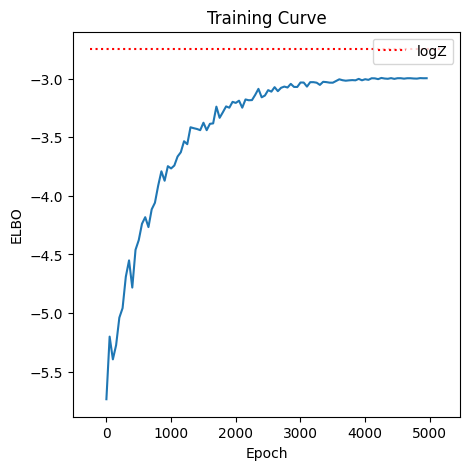

In [21]:
n = 1000
k_0 = torch.tensor([7., 5.])  # assume no "flat" dimensions with k_j = 0
h_0 = torch.tensor([1., 3.])
lambda_0 = (h_0 + 1) / (2 * k_0)
print(k_0)
print(h_0)
print(lambda_0)


dirichlet_on_standard_form = DirichletOn2DStandardForm(
    n=n,
    k_0=k_0,
    lambda_0=lambda_0, 
    lr=0.001, 
    init_params=None
)
logZ = dirichlet_on_standard_form.log_evidence()
print(f"logZ={logZ}")

dirichlet_on_standard_form.run_parameter_optimisation(5000)
fig = dirichlet_on_standard_form.plot_training_curve();
ax = fig.axes[0]
xmin, xmax = ax.get_xlim()
ax.hlines([logZ], xmin, xmax, color="red", linestyle="dotted", label="logZ")
ax.legend()

ValueError: Expected value argument (Tensor of shape (50, 50, 2)) to be within the support (Simplex()) of the distribution Dirichlet(concentration: torch.Size([2])), but found invalid values:
tensor([[[0.0000, 0.0000],
         [0.0000, 0.0204],
         [0.0000, 0.0408],
         ...,
         [0.0000, 0.9592],
         [0.0000, 0.9796],
         [0.0000, 1.0000]],

        [[0.0204, 0.0000],
         [0.0204, 0.0204],
         [0.0204, 0.0408],
         ...,
         [0.0204, 0.9592],
         [0.0204, 0.9796],
         [0.0204, 1.0000]],

        [[0.0408, 0.0000],
         [0.0408, 0.0204],
         [0.0408, 0.0408],
         ...,
         [0.0408, 0.9592],
         [0.0408, 0.9796],
         [0.0408, 1.0000]],

        ...,

        [[0.9592, 0.0000],
         [0.9592, 0.0204],
         [0.9592, 0.0408],
         ...,
         [0.9592, 0.9592],
         [0.9592, 0.9796],
         [0.9592, 1.0000]],

        [[0.9796, 0.0000],
         [0.9796, 0.0204],
         [0.9796, 0.0408],
         ...,
         [0.9796, 0.9592],
         [0.9796, 0.9796],
         [0.9796, 1.0000]],

        [[1.0000, 0.0000],
         [1.0000, 0.0204],
         [1.0000, 0.0408],
         ...,
         [1.0000, 0.9592],
         [1.0000, 0.9796],
         [1.0000, 1.0000]]])

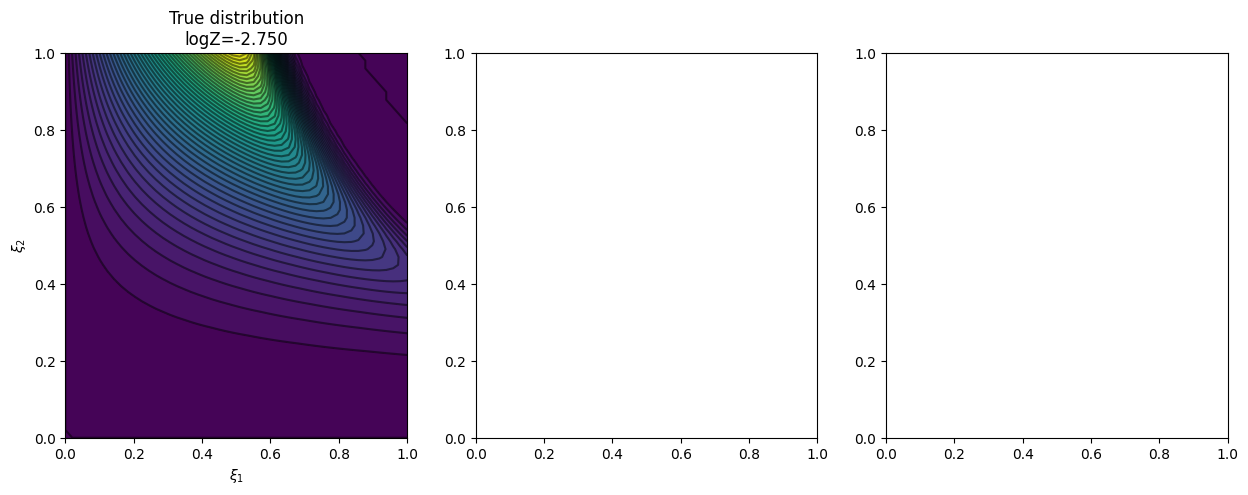

In [22]:
fig, anim = dirichlet_on_standard_form.plot_variational_posterior(animate=True);
if anim is not None:
    video = anim.to_html5_video()
    IPython.display.display(IPython.display.HTML(video))
# anim.save("mf_gamma_trunc_optim_beta1_beta2_on_standard_form.mp4")

# Experiment X: Learning high dimension standard form, comparing Generalised Gamma Mean Field Family with Gaussian Family

# Misc

In [20]:
f = lambda y, x: gaussian_on_standard_form.true_unnormalised_density(torch.tensor([x, y]))
scipy.integrate.dblquad(f, 0, 1, 0, 1)

(0.060759627300232134, 1.284435631123736e-08)

In [21]:

class CustomsFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, y):
        ctx.save_for_backward(x, y)
        return x**2 + 13 * y
    
    @staticmethod
    def backward(ctx, grad_output):
        x, y = ctx.saved_tensors
        return grad_output * 2 * x, grad_output * 13


In [22]:
f = CustomsFunc.apply
x = torch.tensor(3., requires_grad=True)
y = torch.tensor(4., requires_grad=True)
z = f(x, y)
z.backward()

x.grad, y.grad

(tensor(6.), tensor(13.))

In [23]:
x = torch.tensor(3., requires_grad=True)
y = torch.tensor(10., requires_grad=True)
z = igamma(x, y)
z.backward()
x.grad, y.grad

(tensor(-0.4614), tensor(0.2270))

In [24]:
@interact(
    n=(2, 10000), 
    t=(-2.0, 2.0)
)
def _plot_contour(n=50, t=0.5):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    x = np.linspace(-1, 1, num=1000)
    ax.plot(x, np.cos(2 * np.pi * n * (x**4 + t * x)) * (1 - np.exp(-1/x**2)), alpha=0.8)
    ax.plot(x, (1 - np.exp(-1/x**2)), color="r", alpha=0.5)
    ax.plot(x, -(1 - np.exp(-1/x**2)), color="r", alpha=0.5)

interactive(children=(IntSlider(value=50, description='n', max=10000, min=2), FloatSlider(value=0.5, descripti…

In [25]:
x1 = torch.tensor([1.0], requires_grad=False)
x2 = torch.tensor([2.0], requires_grad=True)

optim = torch.optim.Adam([x1, x2], lr=0.1)
for _ in range(10):
    optim.zero_grad()
    x = torch.stack([x1, x2], dim=-1)
#     a = x1**2 + x2**2
    a = torch.sum(x**2)
    a.backward()
    optim.step()
    print(a, x1, x2)

tensor(5., grad_fn=<SumBackward0>) tensor([1.]) tensor([1.9000], requires_grad=True)
tensor(4.6100, grad_fn=<SumBackward0>) tensor([1.]) tensor([1.8002], requires_grad=True)
tensor(4.2406, grad_fn=<SumBackward0>) tensor([1.]) tensor([1.7006], requires_grad=True)
tensor(3.8921, grad_fn=<SumBackward0>) tensor([1.]) tensor([1.6015], requires_grad=True)
tensor(3.5648, grad_fn=<SumBackward0>) tensor([1.]) tensor([1.5030], requires_grad=True)
tensor(3.2589, grad_fn=<SumBackward0>) tensor([1.]) tensor([1.4051], requires_grad=True)
tensor(2.9744, grad_fn=<SumBackward0>) tensor([1.]) tensor([1.3082], requires_grad=True)
tensor(2.7114, grad_fn=<SumBackward0>) tensor([1.]) tensor([1.2123], requires_grad=True)
tensor(2.4698, grad_fn=<SumBackward0>) tensor([1.]) tensor([1.1177], requires_grad=True)
tensor(2.2493, grad_fn=<SumBackward0>) tensor([1.]) tensor([1.0246], requires_grad=True)


In [26]:

x1 = torch.tensor([10.000, 2.0, 3.2])
y1 = torch.tensor([6., 2.0, 1.0])
%time grad_lmbda_lower_incomplete_gamma(x1, y1)

CPU times: user 693 µs, sys: 5 µs, total: 698 µs
Wall time: 382 µs


tensor([0., 0., 0.])

In [27]:
x = x1.numpy()
y = y1.numpy()
def integrand(t, x, y):
    return np.exp(-y * t) * (y * t)**(x-1) * np.log(y * t)
# integrand = lambda t, x, y: np.exp(-y * t) * (y * t)**(x-1) * np.log(y * t)

def f(x, y):
    return scipy.integrate.quad(integrand, 0, 1, args=(x, y))[0] * y

fvec = np.vectorize(f)
# vec_integrand = np.vectorize(integrand)
# %time scipy.integrate.quad(integrand, 0, 1)
%time fvec(x1, y1)

CPU times: user 879 µs, sys: 7 µs, total: 886 µs
Wall time: 890 µs


array([ 4.91165965e+04, -4.28732689e-02, -5.58167725e-02])

In [28]:
grad_lmbda_lower_incomplete_gamma(x1, y1)

tensor([0., 0., 0.])

In [3]:
lmbda = torch.tensor([0.5, 1.5, 2.0, 3.2, 5.0])
beta = torch.tensor([4.5, 1.0, 23.1, 5.0, 2.3])

epsilon = 1e-3
D1_ORD6_STENCIL = torch.tensor([-1.0/60, 3.0/20, -3.0/4, 0.0, 3.0/4, -3.0/20, 1.0/60])
D2_ORD6_STENCIL = torch.tensor([1.0/90, -3.0/20, 3.0/2, -49.0/18, 3.0/2, -3.0/20, 1.0/90])

xs = x0 + torch.arange(-3, 4, step=1, dtype=torch.float) * epsilon
torch.sum(torch.igamma(xs, beta) * D1_ORD6_STENCIL) / epsilon

NameError: name 'x0' is not defined

In [59]:
print(lmbda)
print(beta)

tensor([0.5000, 1.5000, 2.0000, 3.2000, 5.0000])
tensor([ 4.5000,  1.0000, 23.1000,  5.0000,  2.3000])


In [56]:
n = lmbda.shape[0]

deltas = torch.arange(-3, 4, step=1, dtype=torch.float) * epsilon
xs = deltas.repeat((n, 1)).T + lmbda
xs

tensor([[0.4970, 1.4970, 1.9970, 3.1970, 4.9970],
        [0.4980, 1.4980, 1.9980, 3.1980, 4.9980],
        [0.4990, 1.4990, 1.9990, 3.1990, 4.9990],
        [0.5000, 1.5000, 2.0000, 3.2000, 5.0000],
        [0.5010, 1.5010, 2.0010, 3.2010, 5.0010],
        [0.5020, 1.5020, 2.0020, 3.2020, 5.0020],
        [0.5030, 1.5030, 2.0030, 3.2030, 5.0030]])

In [69]:
x = torch.arange(-3, 4, step=1, dtype=torch.float)
x.repeat((3, 1))

tensor([[-3., -2., -1.,  0.,  1.,  2.,  3.],
        [-3., -2., -1.,  0.,  1.,  2.,  3.],
        [-3., -2., -1.,  0.,  1.,  2.,  3.]])

In [64]:
torch.sum(torch.igamma(xs, beta).T * D1_ORD6_STENCIL / epsilon, axis=1)

tensor([-0.0098, -0.3748,  0.0000, -0.1252, -0.0799])

# Some Unit Tests

## Tests for $\gamma(\lambda, \beta)$
This is for (un-regularised) lower incomplete gamma function. 

Testing that as $\beta \to \infty$
$$
\frac{d}{d\lambda}\gamma(\lambda, \beta) \to \psi(\lambda)
$$

<p style="color:red;font-size:large">
    It seem like the following implementation only works for some range of $\lambda$, $\beta$ and becomes numerically unstable elsewhere.....
</p>

In [29]:
def gradgamma(lmbda, beta):
    # reference: Eq 25 for derivative of upper incomplete gamma in 
    # http://www.iaeng.org/IJAM/issues_v47/issue_3/IJAM_47_3_04.pdf
    acc = 0
    for k in range(50):
        term1 = torch.log(beta) / (lmbda + k)
        term1 -= 1 / (lmbda + k)**2
        
        logterm2 = (
            (k + lmbda) * torch.log(beta) - torch.lgamma(torch.tensor([k + 1], dtype=torch.float))
        )
        term2 = torch.exp(logterm2)
        if k % 2 == 1:
            term2 *= -1
        acc += term1 * term2
        
#         print(f"{k:3d}, {term1.item():.5f}, {term2.item():.5f}, {acc.item():.5f}, {(term1 * term2).item():.5f}")
    return acc

def _integrand(t, lmbda, beta, n):
    return np.exp(-beta * t) * (beta * t)**(lmbda-1) * np.log(beta * t)**n

def _integrated1(lmbda, beta):
    return scipy.integrate.quad(_integrand, 0, 1, args=(lmbda, beta, 1))[0] * beta

_vec_integrated = np.vectorize(_integrated1)

def gradgamma_int(lmbda, beta):
    return torch.tensor(_vec_integrated(lmbda, beta))



lmbda = torch.tensor([.5, .5, 1., 1., 2., 2., 10., 10.])
beta = torch.tensor([5., 10., 5., 10., 5., 10., 5., 10.])
print(torch.digamma(lmbda))
x = gradgamma(lmbda, beta)
y = gradgamma_int(lmbda, beta)
print(x.tolist())
print(y.tolist())
print((x - y).tolist())

tensor([-1.9635, -1.9635, -0.5772, -0.5772,  0.4228,  0.4228,  2.2518,  2.2518])
[-3.4851419925689697, -3.4817750453948975, -0.589206874370575, -0.581538736820221, 0.34985923767089844, 0.41425275802612305, 16756.193359375, 4131366.0]
[-3.485140035535015, -3.480263722174373, -0.589208267845169, -0.5773243590717142, 0.34983224839485394, 0.42158486898258063, 16734.905289061047, 396770.57728189195]
[-1.9570339548913296e-06, -0.0015113232205243854, 1.3934745940469284e-06, -0.004214377748506748, 2.6989276044497856e-05, -0.007332110956457583, 21.28807031395263, 3734595.422718108]


/home/edmund/.local/share/virtualenvs/variational-approximation-for-singular-mod-T_CFu1la/lib/python3.9/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/edmund/.local/share/virtualenvs/variational-approximation-for-singular-mod-T_CFu1la/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dty

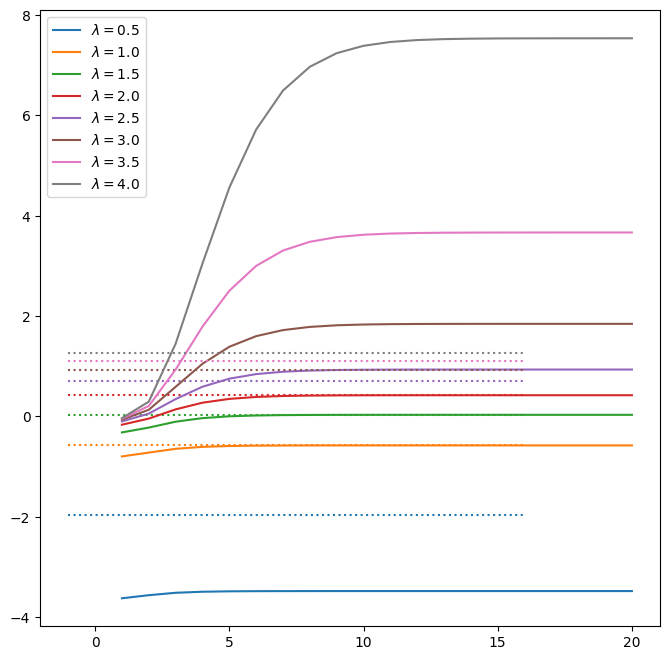

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
bs = torch.linspace(1, 20, steps=20)
for lmbda in [.5, 1., 1.5, 2.0, 2.5, 3.0, 3.5, 4.]:
    lmbda = torch.tensor([lmbda], dtype=torch.float)
    y = [gradgamma_int(lmbda, b) for b in bs]
    p = ax.plot(bs, y, label=f"$\\lambda={lmbda.item()}$")
    xmin, xmax = -1, 16
    ax.hlines([torch.digamma(lmbda).numpy()], xmin, xmax, linestyle="dotted", color=p[0].get_color())
    ax.legend()

## Unit test asymptotic approximation to `elbo_func_mf_gamma_trunc`



In [114]:
igamma = torch.igamma
gradigamma = GradLambdaRegularisedLowerIncompleteGamma.apply # lambda x, y: torch.digamma(x) #
def elbo_func_mf_gamma_trunc(lambdas, ks, betas, lambda_0, k_0, n, ignore_term=True):
    r = k_0 / ks
    iglambdas_betas = igamma(lambdas, betas)
    logbetas = torch.log(betas)
    term1 = n * torch.exp(torch.sum(
        -r * logbetas
        + torch.lgamma(lambdas + r) - torch.lgamma(lambdas)
        + torch.log(igamma(lambdas + r, betas)) - torch.log(iglambdas_betas)
    ))

    term2 = torch.sum(
        torch.log(2 * ks) + lambdas * logbetas 
        - torch.lgamma(lambdas) - torch.log(iglambdas_betas)
        - lambdas * (igamma(lambdas + 1, betas) / iglambdas_betas)
    )
    # this term is the problematic term that involves derivatives of incomplete gamma function. 
    # when lambdas and ks matches the true parameters, this should be zero, 
    # but even there, it would generically has non-zero gradient. 
    if not ignore_term:
        term2 += (lambdas - r * lambda_0) * (gradigamma(lambdas, betas) / iglambdas_betas - logbetas)
    return -term1 - term2

def elbo_func_well_specified(betas, lambda_0, k_0, n):
    lambdas = lambda_0
    ks = k_0
    iglambdas_betas = torch.igamma(lambdas, betas)
    logbetas = torch.log(betas)
    r = 1
    term1 = n * torch.exp(torch.sum(
        -r * logbetas
        + torch.lgamma(lambdas + r) - torch.lgamma(lambdas)
        + torch.log(igamma(lambdas + r, betas)) - torch.log(iglambdas_betas)
    ))

    term2 = torch.sum(
        torch.log(2 * ks) + lambdas * logbetas 
        - torch.lgamma(lambdas) - torch.log(iglambdas_betas)
        - lambdas * (igamma(lambdas + 1, betas) / iglambdas_betas)
    )
    return -term1 - term2


def test_elbo_fn(betas, lambda_0, k_0, n):
    rlct = torch.min(lambda_0)
    assert rlct == lambda_0[0]
    l02 = lambda_0[1]
    
    G = l02 / betas[1] * torch.igamma(l02 + 1, betas[1]) / torch.igamma(l02, betas[1])
    logB = (
        -l02 * torch.log(betas[1]) 
        + torch.lgamma(l02)
        + torch.log(torch.igamma(l02,betas[1])) 
        - torch.log(2 * k_0[1])
    )
    correction1 = torch.lgamma(rlct) - torch.log(2 * k_0[0])
    return rlct * (-torch.log(betas[0]) + 1 - G) + betas[1]*G + logB + correction1


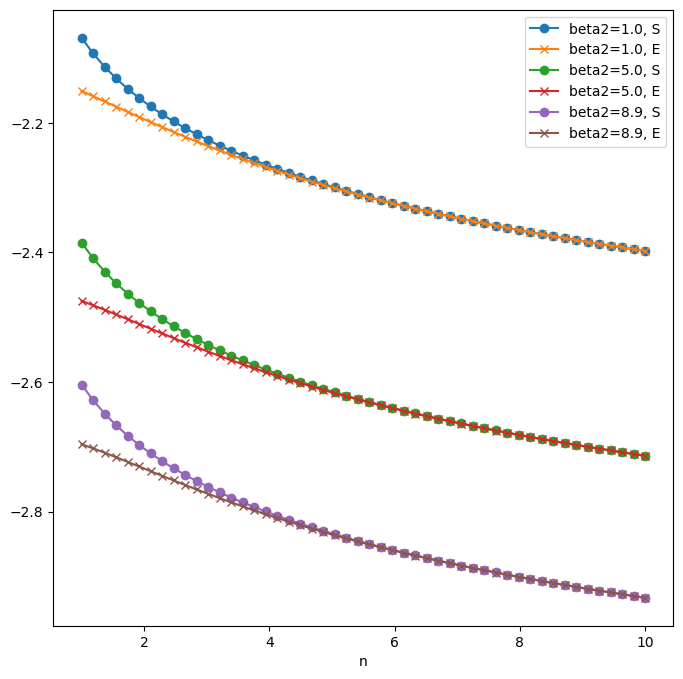

In [117]:

k_0 = torch.tensor([7., 5.])  # assume no "flat" dimensions with k_j = 0
h_0 = torch.tensor([1., 3.])
# k_0 = torch.tensor([3., 3.])  # assume no "flat" dimensions with k_j = 0
# h_0 = torch.tensor([3., 3.])
lambda_0 = (h_0 + 1) / (2 * k_0)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
for beta2 in [1.0, 5.0, 8.9]:
    ns = []
    ts = []
    vs = []
    for n in np.linspace(1, 10, num=50):
#     for logn in range(1, 12):
#         n = 10**logn
        betas = torch.tensor([n, beta2])
        t = test_elbo_fn(betas, lambda_0, k_0, n)
        v = elbo_func_well_specified(betas, lambda_0, k_0, n)
        ns.append(n)
        ts.append(t)
        vs.append(v)
    ax.plot(ns, ts, "o-", label=f"beta2={beta2}, S")
    ax.plot(ns, vs, "x-", label=f"beta2={beta2}, E")
#     ax.set_xscale('log')
    ax.legend()
    ax.set_xlabel("n")

In [ ]:
# beta_1=n, h, k, lambdas well specified, beta_2 free    rlct = lambda_0.min()    print('rlct {}'.format(rlct))    l02 = lambda_0.max()    print('l02 {}'.format(l02))

G = l02 / betas[1] * torch.igamma(l02 + 1, betas[1]) / torch.igamma(l02, betas[1])
print('G {}'.format(G))    
logB = (
    -l02 * torch.log(betas[1]) 
    + torch.lgamma(l02)
    + torch.log(torch.igamma(l02,betas[1])) 
    - torch.log(2 * k_0[1])
)
print('logB {}'.format(logB))

susan = rlct * (-torch.log(betas[0]) + 1 - G) + betas[1]*G + logB
